In [1]:
import cv2
import math
import numpy as np
import os
import mediapipe as mp

from PIL import Image
from matplotlib import transforms

In [2]:
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
    else:
        img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
    return img

In [3]:
def open_img_pil(img_path):
    img = Image.open(img_path) 
    return img

In [4]:
def open_img_opencv(img_path):
    return cv2.imread(img_path)

In [5]:
def get_all_files(data_path):
    files_path_list = []
    for path, subdirs, files in os.walk(data_path):
        for name in files:
            if name.endswith(".jpeg") or name.endswith(".jpg") or name.endswith(".png"):
                files_path_list.append(os.path.join(path, name))
    return files_path_list

In [9]:
img_list = get_all_files("images/frames/")

In [10]:
img_list

['images/frames/mr_bean.jpg', 'images/frames/foto_manoel_2.jpeg']

In [13]:
imgs_resized = []
for image in img_list:
    print(image.split("/")[-1])
    img = open_img_pil(image)
    img_resized = resize_and_show(np.asanyarray(img))
    imgs_resized.append(img_resized)

mr_bean.jpg
foto_manoel_2.jpeg


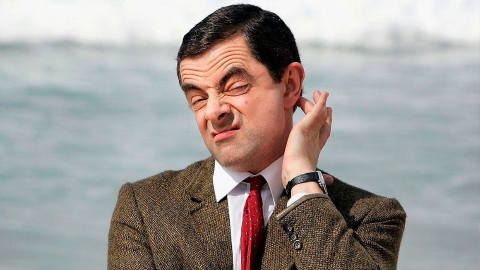

In [15]:
Image.fromarray(np.uint8(imgs_resized[0])) 

## Drawning the landmarks with MediaPipe

In [17]:
mp_face_mesh = mp.solutions.face_mesh

In [18]:
# Load drawing_utils and drawing_styles
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

In [42]:
def get_mediapipe_face_mesh(img_lst):
    # Run MediaPipe Face Mesh.
    images_res = []
    faces_landmarks = []
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        #refine_landmarks=True,
        max_num_faces=2,
        min_detection_confidence=0.5) as face_mesh:
        for image in img_lst:
            # Convert the BGR image to RGB and process it with MediaPipe Face Mesh.
            img_resized = open_img_opencv(image)
            results = face_mesh.process(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))

            # Draw face landmarks of each face.
            print(f'Face landmarks of {image.split("/")[-1]}:')
            if not results.multi_face_landmarks:
                continue
            annotated_image = img_resized.copy()
            for face_landmarks in results.multi_face_landmarks:
                mp_drawing.draw_landmarks(
                  image=annotated_image,
                  landmark_list=face_landmarks,
                  connections=mp_face_mesh.FACEMESH_TESSELATION,
                  landmark_drawing_spec=None,
                  connection_drawing_spec=mp_drawing_styles
                  .get_default_face_mesh_tesselation_style())
                mp_drawing.draw_landmarks(
                  image=annotated_image,
                  landmark_list=face_landmarks,
                  connections=mp_face_mesh.FACEMESH_CONTOURS,
                  landmark_drawing_spec=None,
                  connection_drawing_spec=mp_drawing_styles
                  .get_default_face_mesh_contours_style())
            img_res = resize_and_show(annotated_image)
            images_res.append(img_res)
            faces_landmarks.append(face_landmarks)
    return images_res, faces_landmarks

In [43]:
imgs_mesh_res, faces_landmarks = get_mediapipe_face_mesh(img_list)

Face landmarks of mr_bean.jpg:
Face landmarks of foto_manoel_2.jpeg:


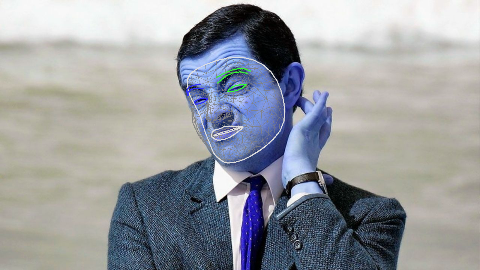

In [44]:
Image.fromarray(np.uint8(imgs_mesh_res[0]))

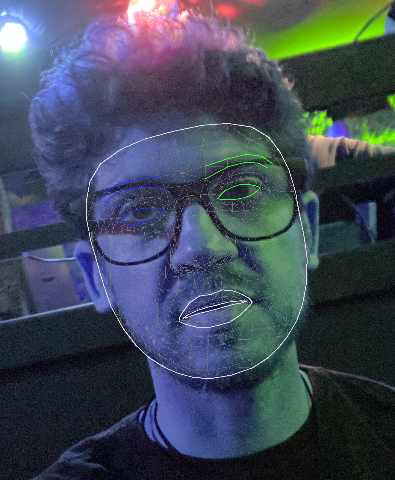

In [45]:
Image.fromarray(np.uint8(imgs_mesh_res[1]))

## Writing the function to extract the landmarks

In [46]:
import dataclasses

from mediapipe.framework.formats import detection_pb2
from mediapipe.framework.formats import landmark_pb2
from typing import List, Mapping, Optional, Tuple, Union

from matplotlib import pyplot as plt

In [47]:
%matplotlib inline

In [48]:
_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5
_RGB_CHANNELS = 3

WHITE_COLOR = (224, 224, 224)
BLACK_COLOR = (0, 0, 0)
RED_COLOR = (0, 0, 255)
GREEN_COLOR = (0, 128, 0)
BLUE_COLOR = (255, 0, 0)

In [49]:
@dataclasses.dataclass
class DrawingSpec:
  # Color for drawing the annotation. Default to the white color.
  color: Tuple[int, int, int] = WHITE_COLOR
  # Thickness for drawing the annotation. Default to 2 pixels.
  thickness: int = 2
  # Circle radius. Default to 2 pixels.
  circle_radius: int = 2

In [50]:
def plot_x_y(img_x,img_y):
    base = plt.gca().transData
    rot = transforms.Affine2D().rotate_deg(180)
    plt.plot(img_x,img_y, 'o', c='black', transform= rot + base)
    plt.show()

In [51]:
def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
    """Converts normalized value pair to pixel coordinates."""

    # Checks if the float value is between 0 and 1.
    def is_valid_normalized_value(value: float) -> bool:
        return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

    if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
        # TODO: Draw coordinates even if it's outside of the image bounds.
        return None
    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)

    return x_px, y_px

In [52]:
def get_landmarks_mediapipe(image: np.ndarray, 
         landmark_list: landmark_pb2.NormalizedLandmarkList,
         connections: Optional[List[Tuple[int, int]]] = None,
         connection_drawing_spec: Union[DrawingSpec, 
                                        Mapping[Tuple[int, int], 
                                                DrawingSpec]] = DrawingSpec()):
  
  
    image_rows, image_cols, _ =  image.shape
    idx_to_coordinates = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        landmark_px = _normalized_to_pixel_coordinates(landmark.x, landmark.y,
                                                       image_cols, image_rows)
        if landmark_px:
            idx_to_coordinates[idx] = landmark_px

    if connections:
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.

    #print(connections)
    for connection in connections:
        start_idx = connection[0]
        end_idx = connection[1]
        #print(start_idx, end_idx)
        if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
            raise ValueError(f'Landmark index is out of range. Invalid connection '
                             f'from landmark #{start_idx} to landmark #{end_idx}.')

        if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
            drawing_spec = connection_drawing_spec[connection] if isinstance(
                connection_drawing_spec, Mapping) else connection_drawing_spec
            
            print("Start: ", idx_to_coordinates[start_idx])
            print("End: ", idx_to_coordinates[end_idx])
            print("Drawing Spec: ", drawing_spec.thickness)
            print("")
            cv2.line(image, idx_to_coordinates[start_idx],
                     idx_to_coordinates[end_idx], drawing_spec.color,
                     drawing_spec.thickness)
            #plt.imshow(image)

    return idx_to_coordinates

In [53]:
def get_landmarks_from_frame(image, face_landmarks):
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        #refine_landmarks=True,
        max_num_faces=2,
        min_detection_confidence=0.5) as face_mesh:

        
        # Convert the BGR image to RGB and process it with MediaPipe Face Mesh.
        image = open_img_opencv(image)
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        annotated_image = image.copy()
        res = get_landmarks_mediapipe(annotated_image, 
                        face_landmarks, 
                        mp_face_mesh.FACEMESH_RIGHT_EYE, 
                        connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())
        return res

In [54]:
import pandas as pd

In [55]:
def get_coord(landmarks, connections):
    x_t, y_t = [], []
    for connection in connections:
        for c in connection:
            print(c)
            x_t.append(landmarks[c][0])
            y_t.append(landmarks[c][1])
    return pd.DataFrame(data={"x":x_t, "y":y_t})

In [56]:
landmarks_frames = []
for image, face_landmarks in zip(img_list, faces_landmarks):
    _landmarks_frame = get_landmarks_from_frame(image, face_landmarks)
    landmarks_frames.append(_landmarks_frame)

Start:  (548, 268)
End:  (552, 265)
Drawing Spec:  2

Start:  (517, 275)
End:  (519, 276)
Drawing Spec:  2

Start:  (518, 273)
End:  (519, 271)
Drawing Spec:  2

Start:  (530, 264)
End:  (537, 262)
Drawing Spec:  2

Start:  (527, 277)
End:  (534, 275)
Drawing Spec:  2

Start:  (550, 262)
End:  (553, 263)
Drawing Spec:  2

Start:  (537, 262)
End:  (545, 261)
Drawing Spec:  2

Start:  (522, 277)
End:  (527, 277)
Drawing Spec:  2

Start:  (542, 272)
End:  (548, 268)
Drawing Spec:  2

Start:  (519, 276)
End:  (522, 277)
Drawing Spec:  2

Start:  (519, 271)
End:  (523, 267)
Drawing Spec:  2

Start:  (545, 261)
End:  (550, 262)
Drawing Spec:  2

Start:  (517, 275)
End:  (518, 273)
Drawing Spec:  2

Start:  (523, 267)
End:  (530, 264)
Drawing Spec:  2

Start:  (534, 275)
End:  (542, 272)
Drawing Spec:  2

Start:  (552, 265)
End:  (553, 263)
Drawing Spec:  2

Start:  (523, 721)
End:  (537, 713)
Drawing Spec:  2

Start:  (401, 739)
End:  (414, 745)
Drawing Spec:  2

Start:  (407, 732)
End:  (41

In [58]:
df_res_coord = get_coord(landmarks_frames[0], mp_face_mesh.FACEMESH_LEFT_EYE)

374
380
390
373
249
390
385
384
373
374
263
466
387
386
381
382
384
398
466
388
386
385
388
387
263
249
380
381
398
362
382
362


In [59]:
mp_face_mesh.FACEMESH_LEFT_EYE

frozenset({(249, 390),
           (263, 249),
           (263, 466),
           (373, 374),
           (374, 380),
           (380, 381),
           (381, 382),
           (382, 362),
           (384, 398),
           (385, 384),
           (386, 385),
           (387, 386),
           (388, 387),
           (390, 373),
           (398, 362),
           (466, 388)})

<AxesSubplot:xlabel='y', ylabel='x'>

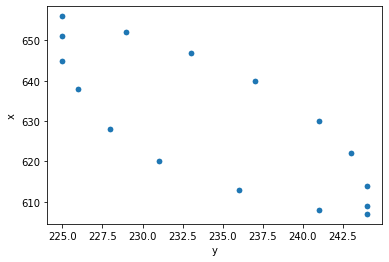

In [60]:
df_res_coord.plot.scatter(x="y", y="x")

In [61]:
df_res_coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       32 non-null     int64
 1   y       32 non-null     int64
dtypes: int64(2)
memory usage: 640.0 bytes


In [62]:
df_res_coord_cont = get_coord(landmarks_frames[0], mp_face_mesh.FACEMESH_CONTOURS)

270
409
176
149
37
0
84
17
318
324
293
334
386
385
7
163
33
246
17
314
374
380
251
389
390
373
267
269
295
285
389
356
173
133
33
7
377
152
158
157
405
321
54
103
263
466
324
308
67
109
409
291
157
173
454
323
388
387
78
191
148
176
311
310
39
37
249
390
144
145
402
318
80
81
310
415
153
154
384
398
397
365
234
127
103
67
282
295
338
297
378
400
127
162
321
375
375
291
317
402
81
82
154
155
91
181
334
296
297
332
269
270
150
136
109
10
356
454
58
132
312
311
152
148
415
308
161
160
296
336
65
55
61
146
78
95
380
381
398
362
361
288
246
161
162
21
0
267
82
13
132
93
314
405
10
338
178
87
387
386
381
382
70
63
61
185
14
317
105
66
300
293
382
362
88
178
185
40
46
53
284
251
400
377
136
172
323
361
13
312
21
54
172
58
373
374
163
144
276
283
53
52
365
379
379
378
146
91
263
249
283
282
87
14
145
153
155
133
93
234
66
107
95
88
159
158
52
65
332
284
40
39
191
80
63
105
181
84
466
388
149
150
288
397
160
159
385
384


<AxesSubplot:xlabel='y', ylabel='x'>

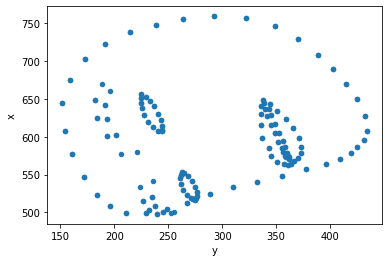

In [63]:
df_res_coord_cont.plot.scatter(x="y", y="x")

In [64]:
df_res_coord_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       248 non-null    int64
 1   y       248 non-null    int64
dtypes: int64(2)
memory usage: 4.0 KB


In [65]:
df_res_coord_tesse = get_coord(landmarks_frames[0], mp_face_mesh.FACEMESH_TESSELATION)  

18
17
82
38
8
9
456
248
167
2
303
271
69
104
253
450
41
42
315
16
73
74
339
373
258
385
105
63
219
48
304
272
236
217
231
22
85
84
365
367
237
218
243
112
436
427
409
410
248
456
330
266
136
135
88
95
394
430
107
108
118
117
439
438
442
443
260
466
115
48
342
276
121
128
200
421
113
124
132
137
23
230
343
357
443
444
62
78
26
155
228
110
432
434
364
379
325
308
424
430
36
205
363
420
21
162
328
462
419
351
366
345
193
8
363
456
183
80
307
375
94
2
333
284
17
313
185
40
44
1
291
287
411
352
20
238
59
166
272
310
420
437
387
260
130
226
51
45
175
377
202
214
353
383
339
448
291
408
466
260
264
454
457
440
355
429
96
89
128
121
187
207
360
278
306
307
446
467
165
39
337
151
168
193
73
41
318
403
263
467
283
445
74
42
201
83
65
222
37
11
429
355
272
408
179
180
100
36
158
157
438
440
358
331
281
456
136
138
314
404
417
8
34
127
367
416
180
181
426
322
419
197
457
309
215
138
242
241
33
247
53
225
126
209
467
359
224
223
271
304
97
2
183
191
202
204
95
78
246
247
177
147
357
343
65
55
116
1

<AxesSubplot:xlabel='y', ylabel='x'>

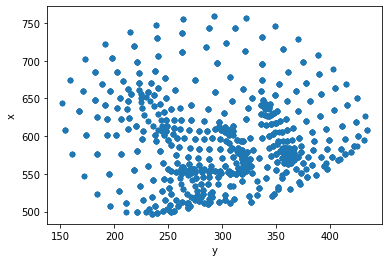

In [66]:
df_res_coord_tesse.plot.scatter(x="y", y="x")

In [67]:
df_res_coord_tesse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5112 entries, 0 to 5111
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       5112 non-null   int64
 1   y       5112 non-null   int64
dtypes: int64(2)
memory usage: 80.0 KB


In [68]:
df_res_coord_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       248 non-null    int64
 1   y       248 non-null    int64
dtypes: int64(2)
memory usage: 4.0 KB


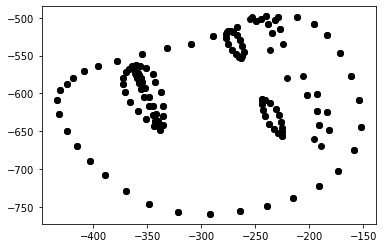

In [69]:
plot_x_y(df_res_coord_cont["y"].values, df_res_coord_cont["x"].values)

In [70]:
help(mp)

Help on package mediapipe:

NAME
    mediapipe - Copyright 2019 - 2020 The MediaPipe Authors.

DESCRIPTION
    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at
    
         http://www.apache.org/licenses/LICENSE-2.0
    
    Unless required by applicable law or agreed to in writing, software
    distributed under the License is distributed on an "AS IS" BASIS,
    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    See the License for the specific language governing permissions and
    limitations under the License.

PACKAGE CONTENTS
    calculators (package)
    examples (package)
    framework (package)
    gpu (package)
    modules (package)
    python (package)
    util (package)

SUBMODULES
    packet_creator
    packet_getter
    resource_util
    solutions

FILE
    /home/manoel/miniconda3/envs/mediapipe39/lib/python3.9/site-pa

### Reducing the Mediapipe points from 468 to 68 using Dlib's landmakrs

In [71]:
import dlib

In [72]:
CASCADE_PATH = "../models/haarcascade_frontalface_default.xml"
PREDICTOR_PATH = "../models/shape_predictor_68_face_landmarks.dat"
INDICESFACE = 68
im_s = 96

In [73]:
cascade = cv2.CascadeClassifier(CASCADE_PATH)
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [74]:
def get_landmarks(im):
    im = np.array(im, dtype="uint8")
    faces = cascade.detectMultiScale(im, 1.15, 4, 0, (100, 100))
    if faces == ():
        return np.matrix(
            [[0 for row in range(0, 2)] for col in range(INDICESFACE)]
        )
    else:
        for (x, y, w, h) in faces:
            rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
        return np.matrix([[p.x, p.y] for p in predictor(im, rect).parts()])

In [75]:
def crop_face(im):
    faces = cascade.detectMultiScale(im, 1.15, 4, 0, (100, 100))
    if faces == ():
        l = np.matrix(
            [[0 for row in range(0, 2)] for col in range(INDICESFACE)]
        )
        rect = dlib.rectangle(0, 0, 0, 0)
        return np.empty(im.shape) * 0, l
    else:
        for (x, y, w, h) in faces:
            rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
            l = np.array(
                [[p.x, p.y] for p in predictor(im, rect).parts()],
                dtype=np.float32,
            )
            sub_face = im[y : y + h, x : x + w]
        return sub_face, l

In [76]:
img_test = open_img_opencv(img_list[0])

In [77]:
a, l = crop_face(img_test)

<ipython-input-75-ee68200b6805>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces == ():


In [78]:
c = get_landmarks(img_test)

<ipython-input-74-f6f0d45dfffa>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces == ():


### Selecting points by interpolation

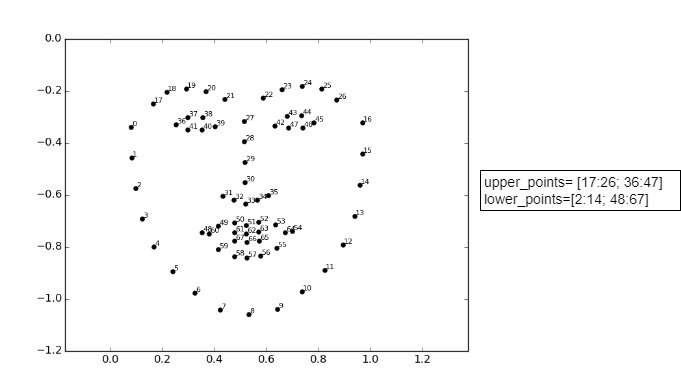

In [82]:
open_img_pil("images/face_pointa_from_dlib.jpg")

In [83]:
def interploating_points(connections: list, step=1):
    indxs = list(map(lambda x: x, [i for i in range(0, len(connections), 1+step)]))
    landmarks_res = []
    for idx_connection in indxs:
        landmarks_res.append(connections[idx_connection])
    return landmarks_res

### Left Eye

In [84]:
left_eye = mp_face_mesh.FACEMESH_LEFT_EYE

In [85]:
landmarks_left_eye_1 = interploating_points(list(left_eye), 1)

In [86]:
landmarks_left_eye_1

[(374, 380),
 (249, 390),
 (373, 374),
 (387, 386),
 (384, 398),
 (386, 385),
 (263, 249),
 (398, 362)]

In [87]:
df_res_let_eye_1 = get_coord(landmarks_frames[0], landmarks_left_eye_1)

374
380
249
390
373
374
387
386
384
398
386
385
263
249
398
362


<AxesSubplot:xlabel='x', ylabel='y'>

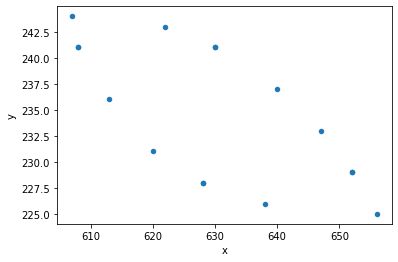

In [88]:
df_res_let_eye_1.plot.scatter(x="x", y="y")

In [89]:
landmarks_left_eye_6 = interploating_points(list(left_eye), 6)

In [90]:
landmarks_left_eye_6

[(374, 380), (381, 382), (398, 362)]

In [91]:
df_left_eye_6 = get_coord(landmarks_frames[0], landmarks_left_eye_6)

374
380
381
382
398
362


<AxesSubplot:xlabel='x', ylabel='y'>

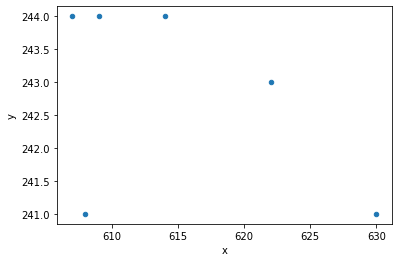

In [92]:
df_left_eye_6.plot.scatter(x="x", y="y")

### Right Eye

In [93]:
right_eye = mp_face_mesh.FACEMESH_RIGHT_EYE

In [94]:
landmarks_right_eye_6 = interploating_points(list(right_eye), 6)

In [95]:
df_right_eye_6 = get_coord(landmarks_frames[0], landmarks_left_eye_6)

374
380
381
382
398
362


<AxesSubplot:xlabel='x', ylabel='y'>

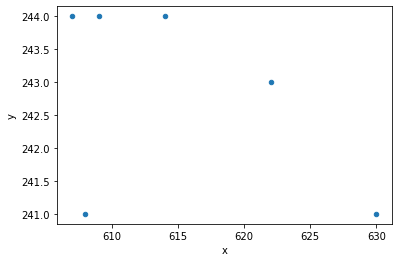

In [96]:
df_right_eye_6.plot.scatter(x="x", y="y")

### Lips

In [97]:
lips = mp_face_mesh.FACEMESH_LIPS

In [98]:
len(list(lips))

40

In [99]:
landmarks_lips_1 = interploating_points(list(lips), 2)

In [100]:
df_lips = get_coord(landmarks_frames[0], landmarks_lips_1)

270
409
91
181
269
270
312
311
61
146
82
13
267
269
88
178
13
312
146
91
95
88
40
39
80
81
375
291


<AxesSubplot:xlabel='x', ylabel='y'>

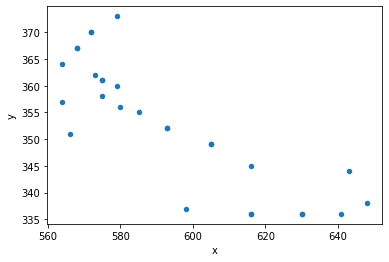

In [101]:
df_lips.plot.scatter(x="x", y="y")

In [102]:
df_lips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       28 non-null     int64
 1   y       28 non-null     int64
dtypes: int64(2)
memory usage: 576.0 bytes


In [103]:
landmarks_face_oval = mp_face_mesh.FACEMESH_FACE_OVAL

In [104]:
df_face_oval = get_coord(landmarks_frames[0], landmarks_face_oval)

176
149
297
332
150
136
109
10
356
454
58
132
152
148
361
288
162
21
251
389
132
93
10
338
389
356
284
251
400
377
136
172
377
152
323
361
54
103
21
54
172
58
67
109
454
323
365
379
379
378
148
176
93
234
332
284
397
365
338
297
149
150
288
397
234
127
103
67
378
400
127
162


<AxesSubplot:xlabel='x', ylabel='y'>

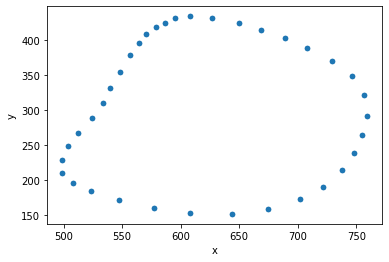

In [105]:
df_face_oval.plot.scatter(x="x", y="y")

In [106]:
df_res = pd.concat([df_left_eye_6, df_right_eye_6])

<AxesSubplot:xlabel='x', ylabel='y'>

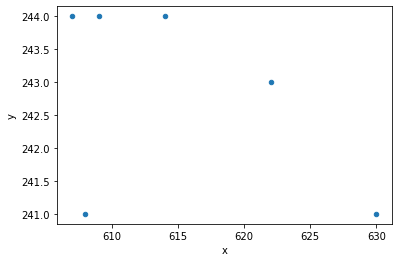

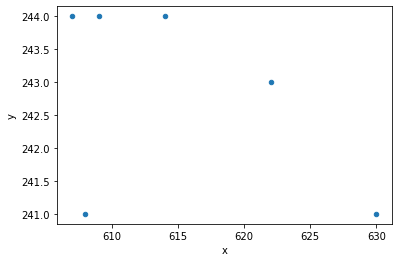

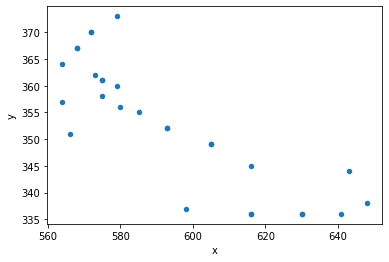

In [107]:
df_left_eye_6.plot.scatter(x="x", y="y")
df_right_eye_6.plot.scatter(x="x", y="y")
df_lips.plot.scatter(x="x", y="y")

### Using the Facemesh Contours

In [108]:
df_res_coord_cont = get_coord(landmarks_frames[0], mp_face_mesh.FACEMESH_CONTOURS)

270
409
176
149
37
0
84
17
318
324
293
334
386
385
7
163
33
246
17
314
374
380
251
389
390
373
267
269
295
285
389
356
173
133
33
7
377
152
158
157
405
321
54
103
263
466
324
308
67
109
409
291
157
173
454
323
388
387
78
191
148
176
311
310
39
37
249
390
144
145
402
318
80
81
310
415
153
154
384
398
397
365
234
127
103
67
282
295
338
297
378
400
127
162
321
375
375
291
317
402
81
82
154
155
91
181
334
296
297
332
269
270
150
136
109
10
356
454
58
132
312
311
152
148
415
308
161
160
296
336
65
55
61
146
78
95
380
381
398
362
361
288
246
161
162
21
0
267
82
13
132
93
314
405
10
338
178
87
387
386
381
382
70
63
61
185
14
317
105
66
300
293
382
362
88
178
185
40
46
53
284
251
400
377
136
172
323
361
13
312
21
54
172
58
373
374
163
144
276
283
53
52
365
379
379
378
146
91
263
249
283
282
87
14
145
153
155
133
93
234
66
107
95
88
159
158
52
65
332
284
40
39
191
80
63
105
181
84
466
388
149
150
288
397
160
159
385
384


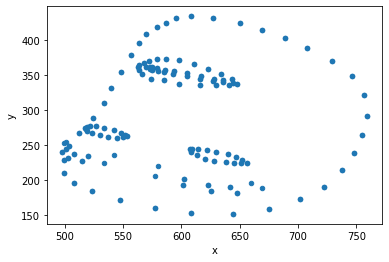

In [109]:
df_res_coord_cont.plot.scatter(x="x", y="y")
plt.savefig("landmarks_mediapipe.jpg")

In [110]:
df_res_coord_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       248 non-null    int64
 1   y       248 non-null    int64
dtypes: int64(2)
memory usage: 4.0 KB


In [111]:
test = list(mp_face_mesh.FACEMESH_CONTOURS)[:32]

In [112]:
landmarks_frames[0][270]

(630, 336)

In [113]:
test

[(270, 409),
 (176, 149),
 (37, 0),
 (84, 17),
 (318, 324),
 (293, 334),
 (386, 385),
 (7, 163),
 (33, 246),
 (17, 314),
 (374, 380),
 (251, 389),
 (390, 373),
 (267, 269),
 (295, 285),
 (389, 356),
 (173, 133),
 (33, 7),
 (377, 152),
 (158, 157),
 (405, 321),
 (54, 103),
 (263, 466),
 (324, 308),
 (67, 109),
 (409, 291),
 (157, 173),
 (454, 323),
 (388, 387),
 (78, 191),
 (148, 176),
 (311, 310)]

In [114]:
df_res_coord_cont_100 = get_coord(landmarks_frames[0], test)

270
409
176
149
37
0
84
17
318
324
293
334
386
385
7
163
33
246
17
314
374
380
251
389
390
373
267
269
295
285
389
356
173
133
33
7
377
152
158
157
405
321
54
103
263
466
324
308
67
109
409
291
157
173
454
323
388
387
78
191
148
176
311
310


In [145]:
mp_face_mesh.FACEMESH_CONTOURS

frozenset({(0, 267),
           (7, 163),
           (10, 338),
           (13, 312),
           (14, 317),
           (17, 314),
           (21, 54),
           (33, 7),
           (33, 246),
           (37, 0),
           (39, 37),
           (40, 39),
           (46, 53),
           (52, 65),
           (53, 52),
           (54, 103),
           (58, 132),
           (61, 146),
           (61, 185),
           (63, 105),
           (65, 55),
           (66, 107),
           (67, 109),
           (70, 63),
           (78, 95),
           (78, 191),
           (80, 81),
           (81, 82),
           (82, 13),
           (84, 17),
           (87, 14),
           (88, 178),
           (91, 181),
           (93, 234),
           (95, 88),
           (103, 67),
           (105, 66),
           (109, 10),
           (127, 162),
           (132, 93),
           (136, 172),
           (144, 145),
           (145, 153),
           (146, 91),
           (148, 176),
           (149, 150),
   

<AxesSubplot:xlabel='x', ylabel='y'>

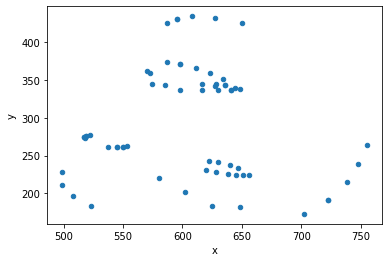

In [115]:
df_res_coord_cont_100.plot.scatter(x="x", y="y")

In [116]:
df_res_coord_cont_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       64 non-null     int64
 1   y       64 non-null     int64
dtypes: int64(2)
memory usage: 1.1 KB


### Using Euclidean Distance

In [117]:
df_dlib_mediapipe = pd.read_csv("data/lands_mp_match_dlib_682d.csv", sep=";")

In [118]:
df_dlib_mediapipe.head()

,Unnamed: 0,landmark,x,y,landmark_mpipe,x_mpipe,y_mpipe
0,0,1,192,477,35,203,478
1,1,2,205,528,228,209,517
2,2,3,220,578,148,237,575
3,3,4,239,630,216,254,627
4,4,5,268,674,139,282,652


### Dlib

In [119]:
points_u = np.empty((21, 2)) * 0

In [120]:
dlib_landmarks = df_dlib_mediapipe[["x", "y"]].values

In [121]:
dlib_landmarks[17:26, :]

array([[203, 406],
       [226, 373],
       [264, 358],
       [303, 354],
       [346, 357],
       [413, 335],
       [450, 307],
       [491, 286],
       [540, 283]])

##### Points Upper

In [122]:
points_u[:9, :] = dlib_landmarks[17:26, :]
points_u[10:, :] = dlib_landmarks[36:47, :]

In [123]:
vp = np.stack((points_u))

In [124]:
vp

array([[203., 406.],
       [226., 373.],
       [264., 358.],
       [303., 354.],
       [346., 357.],
       [413., 335.],
       [450., 307.],
       [491., 286.],
       [540., 283.],
       [  0.,   0.],
       [253., 444.],
       [275., 426.],
       [303., 418.],
       [337., 423.],
       [308., 434.],
       [281., 443.],
       [464., 384.],
       [488., 364.],
       [516., 355.],
       [546., 358.],
       [522., 370.]])

In [125]:
df_dlib_u = pd.DataFrame(vp, columns=["x", "y"])

Text(0.5, 1.0, 'Upper Points - Dlib')

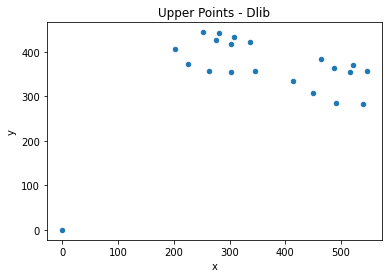

In [126]:
df_dlib_u.plot.scatter(x="x", y="y")
plt.title("Upper Points - Dlib")

##### Points Lower

In [127]:
points_l = np.empty((32, 2)) * 0

In [128]:
points_l[:12, :] = dlib_landmarks[2:14, :]
points_l[13:, :] = dlib_landmarks[48:67, :]
vb = np.stack((points_l))

In [129]:
df_dlib_l = pd.DataFrame(vb, columns=["x", "y"])

Text(0.5, 1.0, 'Lower Points - Dlib')

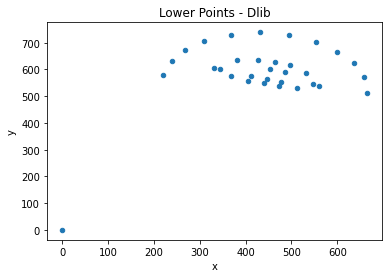

In [130]:
df_dlib_l.plot.scatter(x="x", y="y")
plt.title("Lower Points - Dlib")

In [131]:
def make_X_upper_lower(landmarks):
    points_u = np.empty((21, 2)) * 0
    points_l = np.empty((32, 2)) * 0
    
    points_u[:9, :] = landmarks[17:26, :]
    points_u[10:, :] = landmarks[36:47, :]
    vp = np.stack((points_u))
    
    points_l = np.empty((32, 2)) * 0
    points_l[:12, :] = dlib_landmarks[2:14, :]
    points_l[13:, :] = dlib_landmarks[48:67, :]
    vb = np.stack((points_l))

    vs_brown_e = np.squeeze(np.asarray(landmarks[19] - landmarks[17]))
    vi_brown_e = np.squeeze(np.asarray(landmarks[21] - landmarks[17]))
    vs_brown_d = np.squeeze(np.asarray(landmarks[24] - landmarks[26]))
    vi_brown_d = np.squeeze(np.asarray(landmarks[22] - landmarks[26]))
    a_brown_e = np.arccos(
        np.dot(vs_brown_e, vi_brown_e, out=None)
        / (np.linalg.norm(vs_brown_e) * np.linalg.norm(vi_brown_e))
    )
    a_brown_d = np.arccos(
        np.dot(vs_brown_d, vi_brown_d, out=None)
        / (np.linalg.norm(vs_brown_d) * np.linalg.norm(vi_brown_d))
    )
    v1_eye_e = np.squeeze(np.asarray(landmarks[37] - landmarks[41]))
    v2_eye_e = np.squeeze(np.asarray(landmarks[38] - landmarks[40]))
    v1_eye_d = np.squeeze(np.asarray(landmarks[43] - landmarks[47]))
    v2_eye_d = np.squeeze(np.asarray(landmarks[44] - landmarks[46]))
    vs = np.stack(
        (
            vs_brown_e,
            vi_brown_e,
            vs_brown_d,
            vi_brown_d,
            v1_eye_e,
            v2_eye_e,
            v1_eye_d,
            v2_eye_d,
        )
    )
    d_lips_h1 = np.squeeze(np.asarray(landmarks[48] - landmarks[54]))
    d_lips_h2 = np.squeeze(np.asarray(landmarks[60] - landmarks[64]))
    d_lips_v1 = np.squeeze(np.asarray(landmarks[51] - landmarks[57]))
    d_lips_v2 = np.squeeze(np.asarray(landmarks[62] - landmarks[66]))
    vl = np.stack((d_lips_h1, d_lips_h2, d_lips_v1, d_lips_v2))
    p_u = [vp.tolist(), vs.tolist()]
    points_upper = np.hstack(
        [np.hstack(np.vstack(p_u)), a_brown_e, a_brown_d]
    )
    p_l = [vb.tolist(), vl.tolist()]
    points_lower = np.hstack(np.vstack(p_l)).reshape((36, 2))
    r = cv2.resize(
        a, dsize=(im_s, im_s), interpolation=cv2.INTER_CUBIC
    )
    r = r[:, :, 1]
    upper = np.array(r[:60, :])
    lower = np.array(r[60:, :])
    im_u = np.vstack((upper.T, points_upper))
    im_u = im_u.astype("float32")
    im_u /= 255
    im_l = np.vstack((lower.T, points_lower[:, 0], points_lower[:, 1]))
    im_l = im_l.astype("float32")
    im_l /= 255
    x_upper = np.expand_dims(im_u, axis=0)
    x_lower = np.expand_dims(im_l, axis=0)
    x_upper = x_upper.reshape((1, 60, 97, 1))
    x_lower = x_lower.reshape((1, 36, 98, 1))
    return x_upper, x_lower, vp, vb

In [132]:
dlib_x_upper, dlib_x_lower, x_upper, x_lower = make_X_upper_lower(dlib_landmarks)

#### MediaPipe

<AxesSubplot:xlabel='x', ylabel='y'>

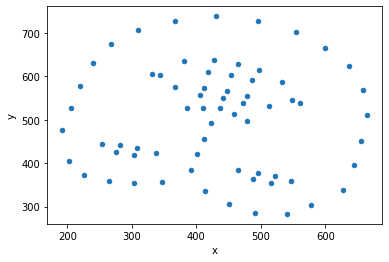

In [133]:
df_dlib_mediapipe.plot.scatter(x="x", y="y")

In [134]:
mediapipe_landmarks = df_dlib_mediapipe[["x_mpipe", "y_mpipe"]].values 

In [135]:
mediapipe_x_upper, mediapipe_x_lower, _, __ = make_X_upper_lower(mediapipe_landmarks)

In [136]:
df_mediapipe_x_upper = pd.DataFrame(x_upper, columns=["x", "y"])

Text(0.5, 1.0, 'Upper Points - MediaPipe')

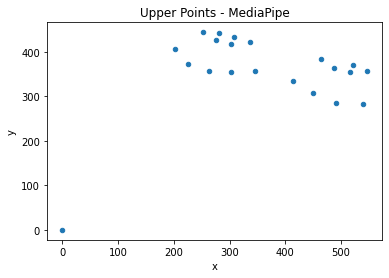

In [137]:
df_mediapipe_x_upper.plot.scatter(x="x", y="y")
plt.title("Upper Points - MediaPipe")

In [138]:
mediapipe_x_upper[0][0][0]

array([0.8784314], dtype=float32)

In [139]:
def get_difference_btw_X(X_1, X_2):
    res = []
    for x_1, x_2 in zip(X_1[0], X_2[0]):
        _r = abs(x_1[0][0] - x_2[0][0])
        res.append(_r)
    return res

In [140]:
res = get_difference_btw_X(dlib_x_upper, mediapipe_x_upper)

In [141]:
max(res)

0.0

#### Using the same IDs taken form Euclidean Distance between MediaPipe and Dlib for others frames

In [142]:
mediapipe_landmarks_ids = df_dlib_mediapipe["landmark_mpipe"].values

In [144]:
mediapipe_landmarks_ids

array([ 35, 228, 148, 216, 139, 137, 150, 149, 153, 401, 379, 366, 398,
       436, 402, 455, 357,  72,  64, 106,  66,  56, 286, 296, 335, 294,
       302, 169, 198,   6,   2,  61, 243, 165, 327, 461, 131, 161, 159,
       156, 146, 145, 382, 386, 388, 256, 391, 375,  58,  75,  38,   1,
       268, 305, 288, 336, 315,  18,  85, 107,  62,  39,  14, 269, 307,
       318,  15,  88])

In [149]:
landmarks_frames[1][mediapipe_landmarks_ids[0]]

(354, 777)

In [199]:
def get_x_y_by_ids(landmarks, mediapipe_ids):
    x, y = [], []
    for mediapipe_id in mediapipe_ids:
        x.append(landmarks[mediapipe_id][0])
        y.append(landmarks[mediapipe_id][1])
    return pd.DataFrame(data=np.transpose([x, y]), columns=["x", "y"])

In [206]:
df_frame_0_res = get_x_y_by_ids(landmarks_frames[0], mediapipe_landmarks_ids)

In [208]:
landmarks_frames

[{0: (585, 343),
  1: (565, 313),
  2: (579, 323),
  3: (556, 283),
  4: (561, 303),
  5: (561, 290),
  6: (564, 258),
  7: (519, 276),
  8: (560, 231),
  9: (555, 218),
  10: (547, 172),
  11: (587, 347),
  12: (590, 351),
  13: (593, 352),
  14: (594, 356),
  15: (594, 360),
  16: (595, 365),
  17: (598, 371),
  18: (606, 383),
  19: (570, 318),
  20: (568, 320),
  21: (504, 249),
  22: (545, 276),
  23: (536, 280),
  24: (529, 282),
  25: (519, 280),
  26: (551, 271),
  27: (523, 253),
  28: (532, 251),
  29: (516, 257),
  30: (513, 263),
  31: (517, 288),
  32: (583, 410),
  33: (517, 275),
  34: (513, 289),
  35: (512, 283),
  36: (541, 318),
  37: (574, 345),
  38: (581, 354),
  39: (566, 351),
  40: (564, 357),
  41: (576, 357),
  42: (572, 359),
  43: (565, 375),
  44: (558, 315),
  45: (554, 306),
  46: (501, 255),
  47: (553, 288),
  48: (550, 318),
  49: (550, 313),
  50: (521, 325),
  51: (554, 293),
  52: (508, 238),
  53: (501, 245),
  54: (499, 229),
  55: (542, 236),
  

In [210]:
mp_face_mesh.FACEMESH_LIPS

frozenset({(0, 267),
           (13, 312),
           (14, 317),
           (17, 314),
           (37, 0),
           (39, 37),
           (40, 39),
           (61, 146),
           (61, 185),
           (78, 95),
           (78, 191),
           (80, 81),
           (81, 82),
           (82, 13),
           (84, 17),
           (87, 14),
           (88, 178),
           (91, 181),
           (95, 88),
           (146, 91),
           (178, 87),
           (181, 84),
           (185, 40),
           (191, 80),
           (267, 269),
           (269, 270),
           (270, 409),
           (310, 415),
           (311, 310),
           (312, 311),
           (314, 405),
           (317, 402),
           (318, 324),
           (321, 375),
           (324, 308),
           (375, 291),
           (402, 318),
           (405, 321),
           (409, 291),
           (415, 308)})

<AxesSubplot:xlabel='x', ylabel='y'>

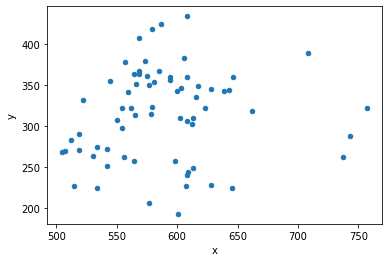

In [203]:
df_frame_0_res.plot.scatter(x="x", y="y")

In [204]:
df_frame_1_res = get_x_y_by_ids(landmarks_frames[1], mediapipe_landmarks_ids)

<AxesSubplot:xlabel='x', ylabel='y'>

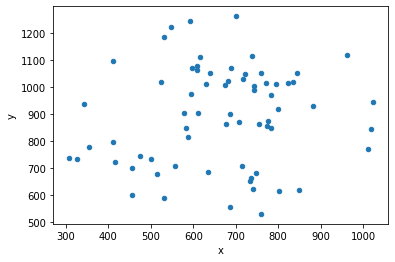

In [211]:
df_frame_1_res.plot.scatter(x="x", y="y")

In [212]:
df_dlib_media_test = pd.read_csv("data/res_mediapipe_dlib.csv", sep=";")

In [214]:
ids = df_dlib_media_test["landmark_mpipe"].values

In [217]:
df_frame_1_res_t = get_x_y_by_ids(landmarks_frames[0], ids)

<AxesSubplot:xlabel='x', ylabel='y'>

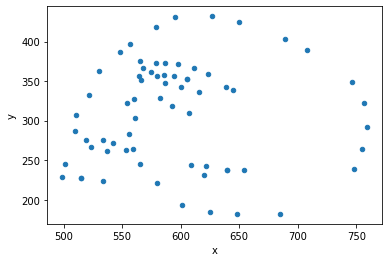

In [219]:
df_frame_1_res_t.plot.scatter(x="x", y="y")

In [220]:
df_frame_1_res_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       68 non-null     int64
 1   y       68 non-null     int64
dtypes: int64(2)
memory usage: 1.2 KB


### Trying using a constant for rotating and mirroring the landmarks

In [116]:
df_res_coord_cont_225 = df_res_coord_cont.copy()

In [84]:
df_res_coord_cont_225 = df_res_coord_cont_225 - (-225)

<AxesSubplot:xlabel='y', ylabel='x'>

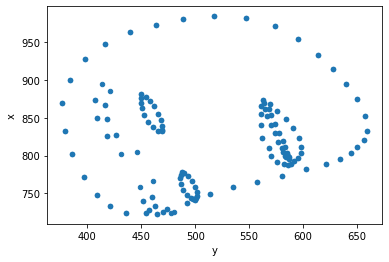

In [85]:
df_res_coord_cont_225.plot.scatter(x="y", y="x")

In [86]:
df_res_coord_cont_450 = df_res_coord_cont.copy()

In [87]:
df_res_coord_cont_450 = df_res_coord_cont_450 - (-450)

<AxesSubplot:xlabel='y', ylabel='x'>

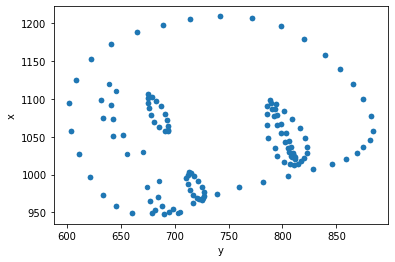

In [88]:
df_res_coord_cont_450.plot.scatter(x="y", y="x")

In [91]:
mp_face_mesh.FACEMESH_LIPS

frozenset({(0, 267),
           (13, 312),
           (14, 317),
           (17, 314),
           (37, 0),
           (39, 37),
           (40, 39),
           (61, 146),
           (61, 185),
           (78, 95),
           (78, 191),
           (80, 81),
           (81, 82),
           (82, 13),
           (84, 17),
           (87, 14),
           (88, 178),
           (91, 181),
           (95, 88),
           (146, 91),
           (178, 87),
           (181, 84),
           (185, 40),
           (191, 80),
           (267, 269),
           (269, 270),
           (270, 409),
           (310, 415),
           (311, 310),
           (312, 311),
           (314, 405),
           (317, 402),
           (318, 324),
           (321, 375),
           (324, 308),
           (375, 291),
           (402, 318),
           (405, 321),
           (409, 291),
           (415, 308)})

In [92]:
landmarks_frames[0]

{0: (585, 343),
 1: (565, 313),
 2: (579, 323),
 3: (556, 283),
 4: (561, 303),
 5: (561, 290),
 6: (564, 258),
 7: (519, 276),
 8: (560, 231),
 9: (555, 218),
 10: (547, 172),
 11: (587, 347),
 12: (590, 351),
 13: (593, 352),
 14: (594, 356),
 15: (594, 360),
 16: (595, 365),
 17: (598, 371),
 18: (606, 383),
 19: (570, 318),
 20: (568, 320),
 21: (504, 249),
 22: (545, 276),
 23: (536, 280),
 24: (529, 282),
 25: (519, 280),
 26: (551, 271),
 27: (523, 253),
 28: (532, 251),
 29: (516, 257),
 30: (513, 263),
 31: (517, 288),
 32: (583, 410),
 33: (517, 275),
 34: (513, 289),
 35: (512, 283),
 36: (541, 318),
 37: (574, 345),
 38: (581, 354),
 39: (566, 351),
 40: (564, 357),
 41: (576, 357),
 42: (572, 359),
 43: (565, 375),
 44: (558, 315),
 45: (554, 306),
 46: (501, 255),
 47: (553, 288),
 48: (550, 318),
 49: (550, 313),
 50: (521, 325),
 51: (554, 293),
 52: (508, 238),
 53: (501, 245),
 54: (499, 229),
 55: (542, 236),
 56: (542, 252),
 57: (556, 368),
 58: (557, 378),
 59: (5